**Clasificación mediante Emsemble model**

<p align="justify">En este capítulo vamos a realizar un ensemble model, para ello vamos a crear un sistema de voto ponderado usando los modelos de atención y el SVM y un emsemble por stacking o apilamiento, para ello usaremos las predicciones de cada modelo como metafeatures de un modelo que entrene con ellas.

In [ ]:
!pip install transformers

In [ ]:
import yaml

# Creamos una función que cree un dataset a partir de un fichero yaml
def yaml_to_dataset(file_path):
    with open(file_path, 'r', encoding="utf8") as file:
        data = yaml.safe_load(file)

    messages = [d['message'] for d in data]
    labels = [d['label'] for d in data]

    return {'data': messages, 'labels': labels}

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Cargamos el dataset
dataset = yaml_to_dataset('/Users/34653/Desktop/new_dataset.yml')

unique_labels = set(dataset['labels'])
num_labels = len(unique_labels)
label_to_index = {label: index for index, label in enumerate(unique_labels)}

data = np.array(dataset['data'])
labels = np.array(dataset['labels'])

data_train, data_val, labels_train, labels_val = train_test_split(data, labels, test_size=0.2, stratify=labels)
data_val, data_test, labels_val, labels_test = train_test_split(data_val, labels_val, test_size = 0.5, stratify=labels_val)


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

# Cargamos el modelo y el tokenizador
bert_tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
bert = TFBertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', num_labels=num_labels)

# Tokenizamos los datos
bert_tokens_train = bert_tokenizer(list(data_train), truncation=True, padding=True, max_length=128, return_tensors='tf')
bert_tokens_val = bert_tokenizer(list(data_val), truncation=True, padding=True, max_length=128, return_tensors='tf')
bert_tokens_test = bert_tokenizer(list(data_test), truncation=True, padding=True, max_length=128, return_tensors='tf')

# Obtenemos los tensores
train_input_ids = bert_tokens_train['input_ids']
val_input_ids = bert_tokens_val['input_ids']
test_input_ids = bert_tokens_test['input_ids']

# Convertimos las etiquetas en índices
train_labels = np.array([label_to_index[label] for label in labels_train])
val_labels = np.array([label_to_index[label] for label in labels_val])
test_labels = np.array([label_to_index[label] for label in labels_test])

# Convertimos arrays las etiquetas en tensores
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)
test_labels = tf.convert_to_tensor(test_labels)

# Creamos tf.data.Datasets
bert_train_data = tf.data.Dataset.from_tensor_slices((train_input_ids, train_labels)).shuffle(10000).batch(32)
bert_val_data = tf.data.Dataset.from_tensor_slices((val_input_ids, val_labels)).batch(32)
bert_test_data = tf.data.Dataset.from_tensor_slices((test_input_ids, test_labels)).batch(32)

# Compilamos el modelo
bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

earlystop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)

# Entrenamos el modelo
bert.fit(bert_train_data, epochs=15, validation_data=bert_test_data, callbacks=[earlystop])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
234/234 [==============================] - 1294s 5s/step - loss: 0.6864 - accuracy: 0.7725 - val_loss: 0.4412 - val_accuracy: 0.8471
Epoch 2/15
234/234 [==============================] - 1146s 5s/step - loss: 0.3281 - accuracy: 0.8910 - val_loss: 0.3931 - val_accuracy: 0.8749
Epoch 3/15
234/234 [==============================] - 1165s 5s/step - loss: 0.1734 - accuracy: 0.9433 - val_loss: 0.4266 - val_accuracy: 0.8684
Epoch 4/15
234/234 [==============================] - 1161s 5s/step - loss: 0.1076 - accuracy: 0.9675 - val_loss: 0.4791 - val_accuracy: 0.8674
Epoch 4: early stopping


In [ ]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

# Cargamos el modelo y el tokenizador
roberta_tokenizer = RobertaTokenizer.from_pretrained('PlanTL-GOB-ES/roberta-base-bne')
roberta = TFRobertaForSequenceClassification.from_pretrained('PlanTL-GOB-ES/roberta-base-bne', num_labels=num_labels, from_pt=True)

# Tokenizamos los datos
roberta_tokens_train = roberta_tokenizer(list(data_train), truncation=True, padding=True, max_length=128, return_tensors='tf')
roberta_tokens_val = roberta_tokenizer(list(data_val), truncation=True, padding=True, max_length=128, return_tensors='tf')
roberta_tokens_test = roberta_tokenizer(list(data_test), truncation=True, padding=True, max_length=128, return_tensors='tf')

# Obtenemos los tensores
roberta_train_input_ids = roberta_tokens_train['input_ids']
roberta_val_input_ids = roberta_tokens_val['input_ids']
roberta_test_input_ids = roberta_tokens_test['input_ids']

# Convertimos las etiquetas en índices
train_labels = np.array([label_to_index[label] for label in labels_train])
val_labels = np.array([label_to_index[label] for label in labels_val])
test_labels = np.array([label_to_index[label] for label in labels_test])

# Convertimos arrays las etiquetas en tensores
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)
test_labels = tf.convert_to_tensor(test_labels)

# Creamos tf.data.Datasets
roberta_train_data = tf.data.Dataset.from_tensor_slices((roberta_train_input_ids, train_labels)).shuffle(10000).batch(32)
roberta_val_data = tf.data.Dataset.from_tensor_slices((roberta_val_input_ids, val_labels)).batch(32)
roberta_test_data = tf.data.Dataset.from_tensor_slices((roberta_test_input_ids, test_labels)).batch(32)

# Compilamos el modelo
roberta.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

earlystop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)

# Entrenamos el modelo
roberta.fit(roberta_train_data, epochs=15, validation_data=roberta_val_data, callbacks=[earlystop])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/15
234/234 [==============================] - 1579s 7s/step - loss: 1.1166 - accuracy: 0.6214 - val_loss: 0.7217 - val_accuracy: 0.7762
Epoch 2/15
234/234 [==============================] - 1100s 5s/step - loss: 0.5839 - accuracy: 0.8134 - val_loss: 0.5157 - val_accuracy: 0.8319
Epoch 3/15
234/234 [==============================] - 1379s 6s/step - loss: 0.3951 - accuracy: 0.8737 - val_loss: 0.5686 - val_accuracy: 0.8255
Epoch 4/15
234/234 [==============================] - 1117s 5s/step - loss: 0.2785 - accuracy: 0.9128 - val_loss: 0.5625 - val_accuracy: 0.8437
Epoch 5/15
234/234 [==============================] - 1360s 6s/step - loss: 0.1939 - accuracy: 0.9366 - val_loss: 0.5958 - val_accuracy: 0.8405
Epoch 6/15
234/234 [==============================] - 1110s 5s/step - loss: 0.1470 - accuracy: 0.9529 - val_loss: 0.6054 - val_accuracy: 0.8437
Epoch 7/15
234/234 [==============================] - 1295s 6s/step - loss: 0.1210 - accuracy: 0.9628 - val_loss: 0.6446 - val_accuracy:

In [ ]:
import re
import string
import unicodedata
import spacy
from spacy.lang.es.stop_words import STOP_WORDS

# Creamos la función auxiliar para reemplazar las abreviaturas
def replace_abbreviations(text, abbreviations):

    for key, value in abbreviations.items():
        text = re.sub(r'\b{}\b'.format(key), value, text)
    return text


abbreviations = {
    'x' : 'por',
    'xq': 'porque',
    'pq': 'porque',
    'k': 'que',
    'tb': 'también',
    'tmb': 'también',
    'd': 'de',
    'cn': 'con',
    'm': 'me',
    'q': 'que',
    'qe': 'que',
    't': 'te',
}

nlp = spacy.load('es_core_news_lg')

# Creamos la función para preprocesar y tokenizar el dataset
def preprocess_tokenize_spanish(text):

  # Pasamos todo el texto a minúsculas
  text = text.lower()

  # Reemplazamos las abreviaturas
  text = replace_abbreviations(text, abbreviations)

  # Borramos las URL que puedan contener los mensajes
  text = re.sub(r'http\S+', '', text)

  # Cargamos una lista de signos de puntuación para eliminarlos al preprocesar
  punctuations = string.punctuation + '...' + '--' + '``' + '\'' + ''
  text = text.translate(str.maketrans('', '', punctuations))

  # Reemplazamos las letras acentuadas por sus equivalentes no acentuadas
  text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')

  # Tokenizamos y generalizamos
  doc = nlp(text)
  tokens = [token.lemma_ for token in doc if token not in STOP_WORDS]

  return tokens

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings

# Ignoramos los warnings de la categoría UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

# Importamos el clasificador
from sklearn.svm import SVC

# Realizamos el preprocesamiento de cada conjunto
vectorizer = TfidfVectorizer(tokenizer=preprocess_tokenize_spanish)
vectors_train = vectorizer.fit_transform(data_train)
vectors_test = vectorizer.transform(data_test)

# Creamos el clasificador
svm = SVC(kernel='rbf', class_weight='balanced', probability=True)

# Realizamos el entrenamiento
svm.fit(vectors_train, labels_train)

SVC(class_weight='balanced', probability=True)

In [ ]:
bert_predicts = bert.predict(bert_test_data).logits
roberta_predicts = roberta.predict(roberta_test_data).logits
bert_predicts = tf.nn.softmax(bert_predicts, axis=-1).numpy()
roberta_predicts = tf.nn.softmax(roberta_predicts, axis=-1).numpy()
svm_predicts = svm.predict_proba(vectors_test)


30/30 [==============================] - 46s 2s/step


                          precision    recall  f1-score   support

            Duda teorica       0.91      0.90      0.90       224
                  Envios       0.63      0.75      0.69        16
              Motivacion       0.92      0.93      0.92        99
        Neurolinguistica       1.00      0.86      0.92         7
                 Pedidos       0.58      0.83      0.68        30
        Problema tecnico       0.83      0.70      0.76       132
Solicitud de informacion       0.89      0.91      0.90       427

                accuracy                           0.87       935
               macro avg       0.82      0.84      0.83       935
            weighted avg       0.88      0.87      0.87       935





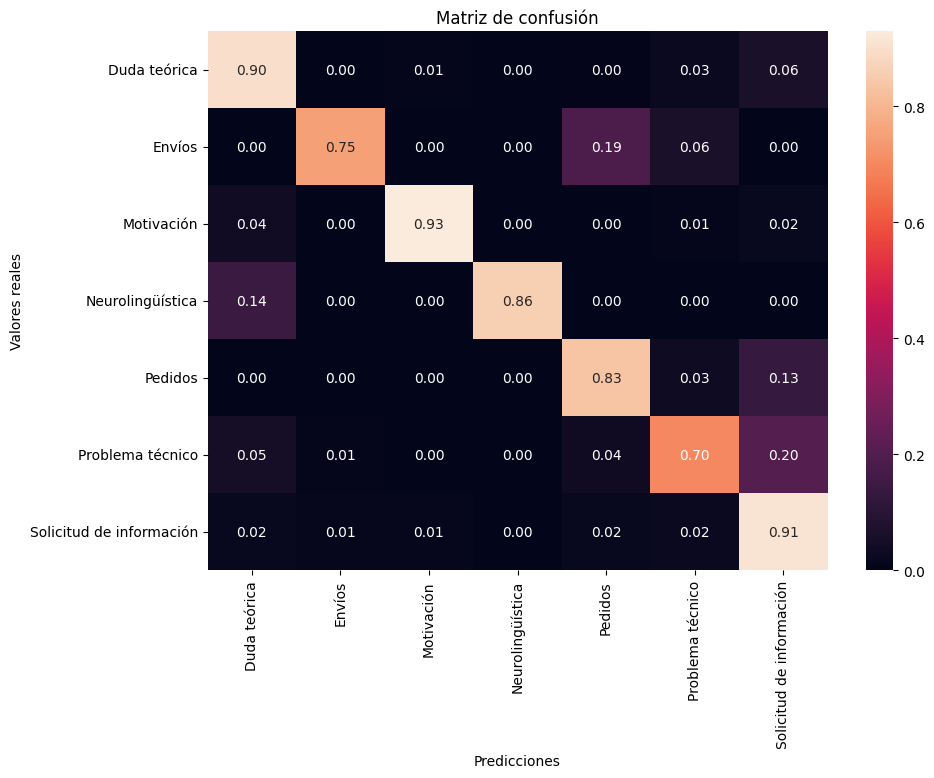

In [ ]:
weights = [0.65, 0.25, 0.10]

def weighted_vote(predictions, weights):
    combined_probs = np.zeros_like(predictions[0])
    for i, probs in enumerate(predictions):
        combined_probs += probs * weights[i]
    return np.argmax(combined_probs, axis=1)

ensemble_predictions = weighted_vote([bert_predicts, roberta_predicts, svm_predicts], weights)
index_to_label = {index: label for label, index in label_to_index.items()}
ensemble_labels_str = [index_to_label[index] for index in ensemble_predictions]


print(classification_report(ensemble_labels_str, labels_test))
print('\n')
matriz_confusion = confusion_matrix(ensemble_labels_str, labels_test)
matriz_confusion_norm = matriz_confusion.astype('float') / matriz_confusion.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,7))
sns.heatmap(matriz_confusion_norm, annot=True, fmt='.2f', xticklabels=index, yticklabels=index)
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión')
plt.show()

In [ ]:
bert_preds_train = bert.predict(bert_train_data)
roberta_preds_train = roberta.predict(roberta_train_data)
svm_preds_train = svm.predict(vectors_train)

234/234 [==============================] - 329s 1s/step


In [ ]:
bert_logits = bert_preds_train.logits
print("bert_logits shape:", np.array(bert_logits).shape)

roberta_logits = roberta_preds_train.logits
print("roberta_logits shape:", np.array(roberta_logits).shape)

print("svm_preds_train shape:", svm_preds_train.shape)

bert_logits shape: (7474, 7)
roberta_logits shape: (7474, 7)
svm_preds_train shape: (7474,)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
svm_onehot = encoder.fit_transform(svm_preds_train.reshape(-1, 1))

print("svm_onehot shape:", svm_onehot.shape)

svm_onehot shape: (7474, 7)


C:\Users\34653\anaconda3\envs\colab\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
X_train_meta = np.column_stack([bert_logits, roberta_logits, svm_onehot])
meta_model = LogisticRegression(solver='saga', multi_class='multinomial', class_weight='balanced')
meta_model.fit(X_train_meta, labels_train)

LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='saga')

                          precision    recall  f1-score   support

            Duda teorica       0.86      0.88      0.87       214
                  Envios       0.63      0.80      0.71        15
              Motivacion       0.82      0.92      0.87        89
        Neurolinguistica       1.00      0.86      0.92         7
                 Pedidos       0.58      0.74      0.65        34
        Problema tecnico       0.65      0.76      0.70        95
Solicitud de informacion       0.94      0.85      0.89       481

                accuracy                           0.85       935
               macro avg       0.78      0.83      0.80       935
            weighted avg       0.86      0.85      0.85       935





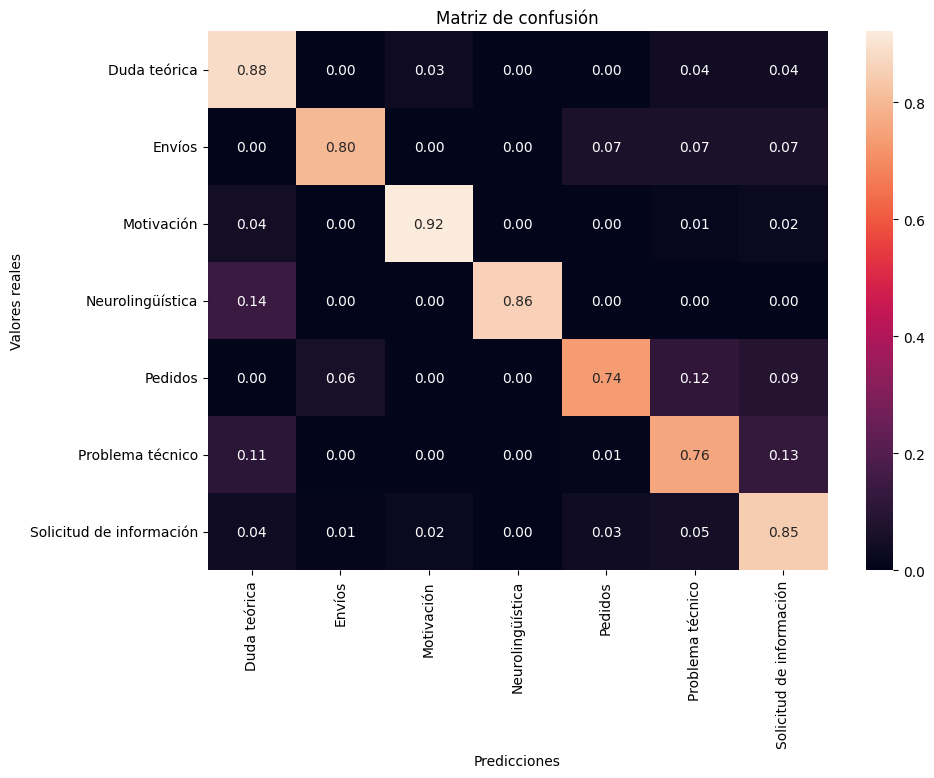

In [ ]:
X_test_meta = np.column_stack([bert_predicts, roberta_predicts, svm_predicts])
meta_predicts = meta_model.predict(X_test_meta)
print(classification_report(meta_predicts, labels_test))
print('\n')
matriz_confusion = confusion_matrix(meta_predicts, labels_test)
matriz_confusion_norm = matriz_confusion.astype('float') / matriz_confusion.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,7))
sns.heatmap(matriz_confusion_norm, annot=True, fmt='.2f', xticklabels=index, yticklabels=index)
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión')
plt.show()